In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import plotly.express as px

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)


In [5]:
source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31")
spots_path = source_path / "recon/out"
spots_df = pd.read_csv(spots_path / "tracked_spots.csv")
spots_df.set_index("ID", inplace=True)
save_path = spots_path
segmentation_path = source_path / "cellpose"

In [10]:
raw = tifffile.imread(segmentation_path / "recon_fused_tp_307_ch_0.tif")
seg = tifffile.imread(segmentation_path / "recon_fused_tp_307_ch_0_masks.tif")[0]

In [139]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]
frame = best_spots["FRAME"].max()
frame_spots = best_spots[best_spots["FRAME"] == frame]

pid = np.array(frame_spots.index)
tid = np.array(frame_spots["track_id"].values)
pos = np.array(frame_spots[["POSITION_X", "POSITION_Y", "POSITION_Z"]]).astype(int)

knn.fit(pos)
k = 10
distances, indices = knn.kneighbors(pos, k)

pid_in = np.stack([pid] * k, -1).flatten()
tid_in = np.stack([tid] * k, -1).flatten()

pid_out = pid[np.array(indices)].flatten()
tid_out = tid[np.array(indices)].flatten()

tid_graph = nx.Graph(zip(tid_in, tid_out))
pid_graph = nx.Graph(zip(pid_in, pid_out))
tid_graph.remove_edges_from(nx.selfloop_edges(tid_graph))
pid_graph.remove_edges_from(nx.selfloop_edges(pid_graph))

tid_colors = nx.greedy_color(tid_graph)
pid_colors = frame_spots["track_id"].map(tid_colors)
# print(np.max(list(tid_colors.values())))
print(pd.Series(tid_colors.values()).value_counts() / len(tid_colors.values()))
print(pd.Series(tid_colors.values()).value_counts().index.values)

pos_arr = pos[:, ::-1]
print(pos.max(axis=0))
print(seg.shape)
print(pos_arr)
seg_label_colors = seg[*np.moveaxis(pos_arr, -1, 0)]
slc = {label: color for label, color in zip(seg_label_colors, pid_colors) if label !=0}
others = seg_label_colors[seg_label_colors == 0]
print(len(others))
slc.update({l: -1 for l in others})
print(len(slc))

2    0.204327
3    0.201923
1    0.192308
0    0.180288
4    0.163462
5    0.045673
6    0.009615
7    0.002404
Name: count, dtype: float64
[2 3 1 0 4 5 6 7]
[339 895 342]
(361, 901, 378)
[[ 61 595 287]
 [113 511 319]
 [ 71 544 291]
 ...
 [115 780 320]
 [ 82 560 302]
 [ 56 715 289]]
61
4872


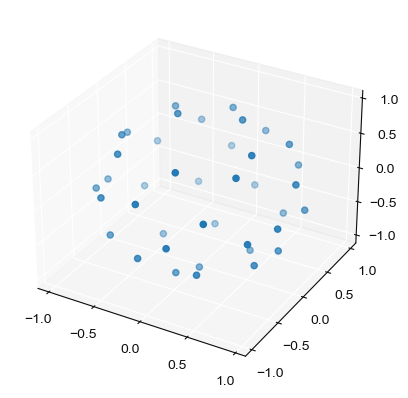

In [141]:
from skimage.measure import regionprops
from dipy.reconst.shm import sf_to_sh, sh_to_sf
from dipy.core.sphere import Sphere, fibonacci_sphere
from dipy.core.geometry import sphere2cart, cart2sphere
from scipy.spatial import ConvexHull
from time import time

n = 40
# goldenRatio = (1 + 5**0.5)/2
# i = np.arange(0, n)
# theta = 2 * np.pi * i / goldenRatio
# phi = np.arccos(1 - 2*(i+0.5)/n)
# x, y, z = sphere2cart(1, theta, phi)
pts = fibonacci_sphere(n)
x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
_, theta, phi = cart2sphere(x, y, z)

# print(np.linalg.norm(np.stack([x, y, z], axis=-1), axis=-1))
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
plt.show()

hull = ConvexHull(pts)
tri = hull.simplices
edges = hull.neighbors

k = 12
# arange = np.arange(-k + 1, k)
# x, y, z = arange.copy(), arange.copy(), arange.copy()
# xx, yy, zz = np.meshgrid(x, y, z)

def indices_along_vector(start_index, direction_vector, num_steps):
    start_index = np.array(start_index)
    direction_vector = np.array(direction_vector)
    indices = np.round(start_index + np.arange(num_steps)[:, None] * direction_vector).astype(int)
    return indices


indices = []
for xx, yy, zz in zip(x, y, z):
    indices.append(indices_along_vector((0, 0, 0), (xx, yy, zz), k))
    
indices = np.array(indices)

test = indices + np.array((27, 591, 187))

seg_buff = np.pad(seg, k)
# print(seg.shape, seg_buff.shape)

centroids = []
labels = []
colors = []
for i, prop in zip(range(10000), regionprops(seg, intensity_image=raw)):
    centroids.append(np.round(prop.centroid).astype(int))
    labels.append(prop.label)
    colors.append(slc.get(prop.label, -1))

labels = np.array(labels)

ts = time()
ind_bc, centroid_bc = [np.array(a) for a in np.broadcast_arrays(np.expand_dims(indices, 0), np.expand_dims(centroids, [1, 2]))]
take_seg = seg_buff[*np.moveaxis(centroid_bc + ind_bc + k, -1, 0)]
pts = take_seg - np.expand_dims(labels, [1, 2])
# print(pts)
# print(np.argwhere(pts[:, :, 0] != 0))
# print(pts[842])
dis = np.argmax(pts != 0, axis=-1)
sphere = Sphere(theta=theta, phi=phi)
sh = sf_to_sh(dis, sphere)
sf = sh_to_sf(sh, sphere)

locs = np.stack(np.array(sphere2cart(sf, theta, phi)), -1)
# print(locs)
locs = locs + np.expand_dims(centroids, 1)
blender_tri = np.broadcast_arrays(np.expand_dims(np.arange(len(locs)), [1, 2]), np.expand_dims(tri, 0))[1]
# print(blender_tri)



np.save(save_path / "verts.npy", locs)
np.save(save_path / "faces.npy", blender_tri)
np.save(save_path / "colors.npy", colors)


# print(np.sum(dis == 0))

, Spherical Harmonics

1. choose an order n, 3d radius max R
2. create integer grid in 3d space centered around 0 with radius R
3. calculate phi, theta, r for each pt in 3d space
4. calculate Y_j(phi, theta) for each spherical harmonic j up to order n

Model architecture
input: raw data of grid size
output: pixel probabilities of nucleus centered in input
early layers: convolutional? *fully connected*?
final layer: vector C of size Y
loss fn: (sig(Y.C - r) - y)^2 

Model training
1. use 3d cellpose output as ground truth
2. crop raw data, cellpose binary mask around every detection